# Setup

### Activate inline plotting

In [1]:
%pylab inline
import sys
sys.path.insert(0, '..')

Populating the interactive namespace from numpy and matplotlib


### Import Dataset(s)

In [2]:
from data import Dataset

In [3]:
signal = Dataset('../data/signal_TDR.root')

### Drawing Function(s)

In [4]:
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85)   

### Sandbox

In [5]:
print sorted(set(signal.track_rhos))
print len(set(signal.track_phis))

[19.600000000000001, 26.850000000000001, 34.099999999999994, 41.349999999999994, 48.599999999999994]
20


In [7]:
print signal.total_wires
print sum(signal.wires_by_layer)

4482
4482


/usr/lib64/python2.7/site-packages/scipy/sparse/lil.py:233: SparseEfficiencyWarning: Indexing into a lil_matrix with multiple indices is slow. Pre-converting to CSC or CSR beforehand is more efficient.
  SparseEfficiencyWarning)


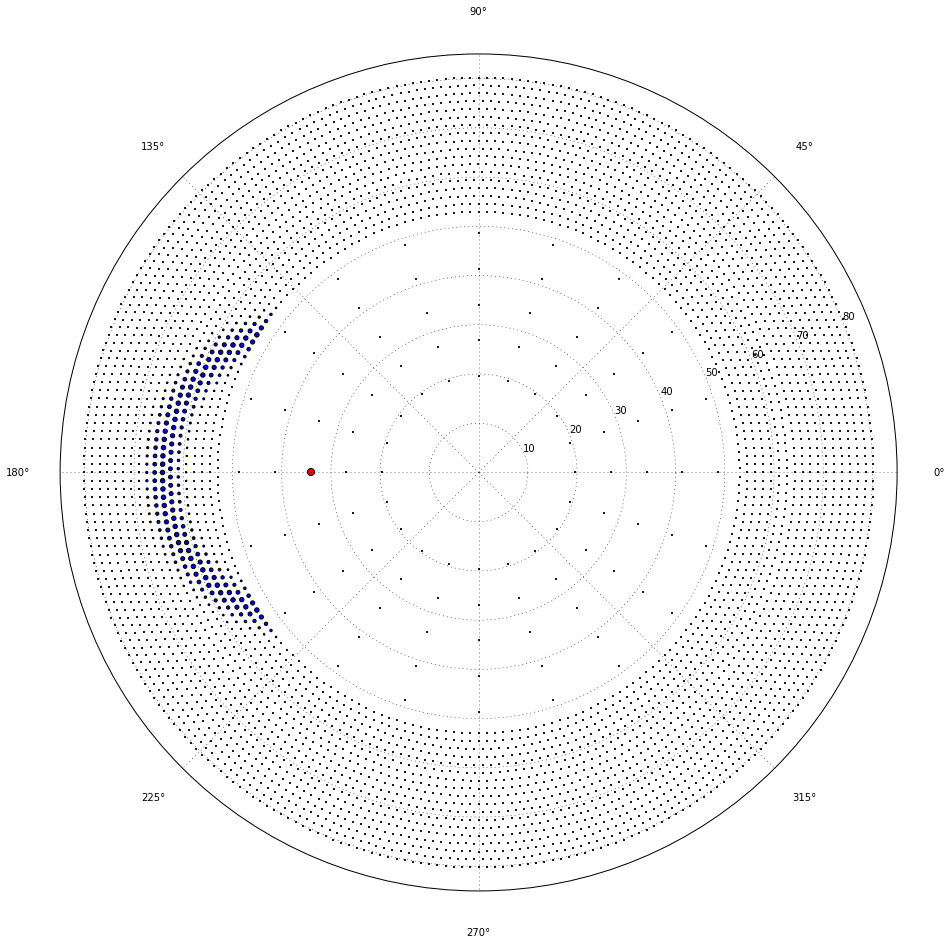

In [6]:
from scipy.sparse import *
trk_0 = 50
corr_track = find(signal.correspondence[:,trk_0])[0]
signal_size = find(signal.correspondence[:,trk_0])[2]
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()
t_rhos, t_phis = signal.get_tracks_rhos_and_phis()
scatter(phis, rhos, marker='.', s=5)
scatter(t_phis, t_rhos, marker='.', s=5)

scatter(phis[corr_track],rhos[corr_track], signal_size*100, marker='o', c='b')
scatter(t_phis[trk_0],t_rhos[trk_0], marker='o', s=50, c='r')

In [12]:
import numpy as np

### Current neighbours algorithm

In [7]:
test_neigh = lil_matrix((signal.total_wires, signal.total_wires))
first_wire = 0
for lay, layer_size in enumerate(signal.wires_by_layer):
    for wire_index in range(layer_size):
        this_wire = wire_index + first_wire
        next_wire = first_wire + (wire_index + 1)%layer_size
        test_neigh[next_wire, this_wire] = 1  # Clockwise
        test_neigh[this_wire, next_wire] = 1  # Anti-Clockwise
        if lay != len(signal.wires_by_layer) - 1:
            wire_a = signal.wire_phis[this_wire]
            angle_win = signal.dphi_by_layer[lay + 1] * 1.5
            above = np.where(
                     (signal.wire_rhos == signal.r_layers[lay + 1]) &
                     ((abs(wire_a - signal.wire_phis) < angle_win) |
                     (2*math.pi - abs(wire_a - signal.wire_phis) < angle_win)
                     ))[0]
            test_neigh[this_wire, above[:]] = 1 # Above
        if lay != 0:
            wire_a = signal.wire_phis[this_wire]
            angle_win = signal.dphi_by_layer[lay - 1] * 1.5
            below = np.where(
                 (signal.wire_rhos == signal.r_layers[lay - 1]) &
                 ((abs(wire_a - signal.wire_phis) < angle_win) |
                 (2*math.pi - abs(wire_a - signal.wire_phis) < angle_win)
                 ))[0]
            test_neigh[this_wire, below[:]] = 1 # Below
    first_wire += layer_size

In [13]:
bad_neighs = np.zeros(signal.total_wires)
n_bad = 0

for wire in range(signal.total_wires):
    n_neigh = len(find(test_neigh[:,wire])[0])
    if (wire < signal.first_wire[1]) or (wire > signal.first_wire[-1]):
        if n_neigh != 5:
            bad_neighs[wire] = n_neigh
    else:
        if n_neigh !=8:
            bad_neighs[wire] = n_neigh

KeyboardInterrupt: 

276
276


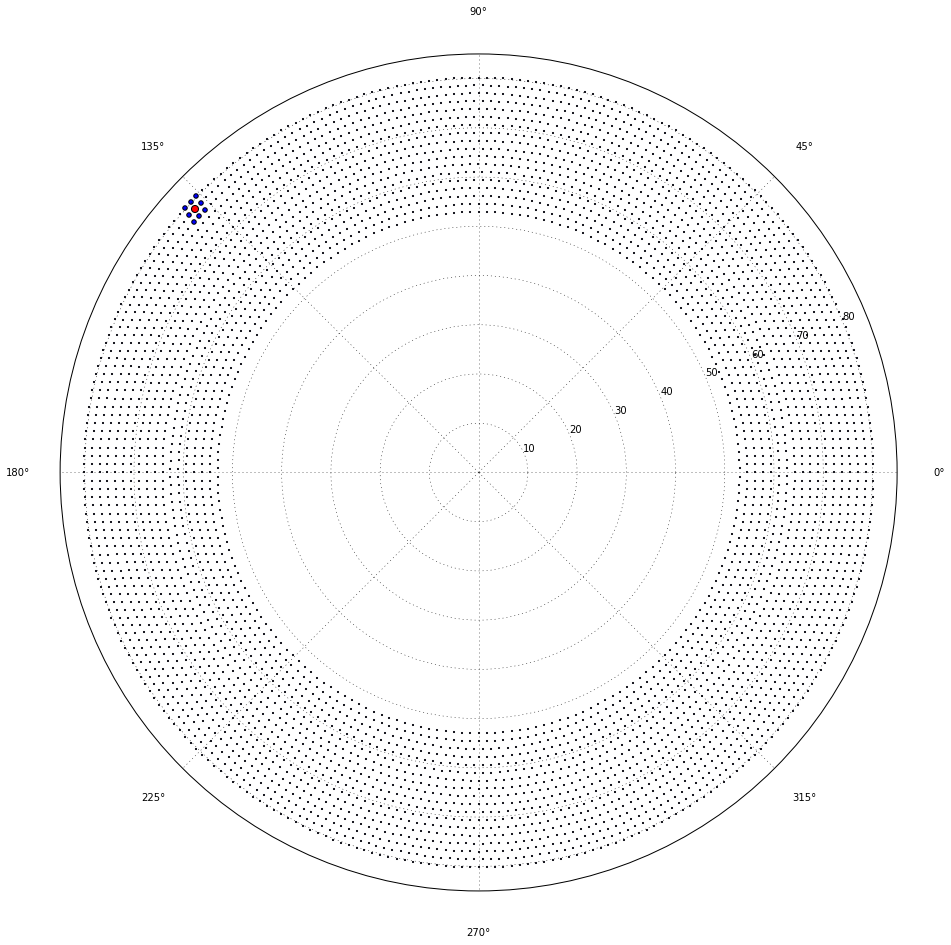

In [96]:
from scipy.sparse import *
wire_0 = 4000
neigh = find(test_neigh[wire_0,:])[1]
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()

scatter(phis, rhos, marker='.', s=5)

#scatter(phis[neigh],rhos[neigh], marker='o', c='b')
#scatter(phis[wire_0],rhos[wire_0], marker='o', s=50, c='r')

bad_neigh_index = where( (bad_neighs!=0))

few_neigh = where( ( (bad_neighs <= 5) & (bad_neighs!=0) ) | (bad_neighs == 7) )

many_neigh = where( (bad_neighs == 6) | (bad_neighs >= 8)  ) 

print len(bad_neigh_index[0])
print len(many_neigh[0]) + len(few_neigh[0])

scatter(phis[few_neigh],rhos[few_neigh], marker='o', s=50, c='b')
scatter(phis[many_neigh],rhos[many_neigh], marker='o', s=50, c='r')


### Accurate Neighbours Algorithm

In [23]:
test_neigh_2 = lil_matrix((signal.total_wires, signal.total_wires))

for lay, n_wires in enumerate(signal.wires_by_layer):
    if lay == 0:
        adjacent_layers = [lay+1]
    elif lay == len(signal.wires_by_layer) - 1:
        adjacent_layers = [lay-1]
    else:
        adjacent_layers = [lay-1,lay+1]
    for wire_index in range(n_wires):
        wire = wire_index +  signal.first_wire[lay]
        nxt_wire = (wire_index + 1)%n_wires + signal.first_wire[lay]
        test_neigh_2[nxt_wire, wire] = 1  # Clockwise
        test_neigh_2[wire, nxt_wire] = 1  # Anti-Clockwise
        rel_pos = signal.wire_phis[wire]/(2*math.pi)

        for a_lay in adjacent_layers:
            a_n_wires = signal.wires_by_layer[a_lay] 
            a_first = signal.first_wire[a_lay]
            a_wire = rel_pos - (signal.phi0_by_layer[a_lay]/(2*math.pi))
            a_wire *= a_n_wires
            a_wire = round(a_wire)
            a_wire %= a_n_wires
            nxt_a_wire = (a_wire+1)%a_n_wires
            prv_a_wire = (a_wire-1)%a_n_wires
            a_wire += a_first
            nxt_a_wire += a_first
            prv_a_wire += a_first
            test_neigh_2[wire, a_wire] = 1 # Above/Below
            test_neigh_2[wire, nxt_a_wire] = 1  # Above/Below Clockwise
            test_neigh_2[wire, prv_a_wire] = 1   # Above/Below Counter Clockwise
            
test_neigh_2 = test_neigh_2.tocsr()

In [24]:
print find(test_neigh_csr[100,:])[1]
print find(test_neigh_2[100,:])[1]

NameError: name 'test_neigh_csr' is not defined

### Testing for number of neighbour

In [28]:
bad_neighs_2 = np.zeros(signal.total_wires)
n_bad = 0

for wire in range(signal.total_wires):
    n_neigh = len(find(signal.wire_neighbours[wire,:])[1])
    if (wire < signal.first_wire[1]) or (wire >= signal.first_wire[-1]):
        if n_neigh != 5:
            bad_neighs_2[wire] = n_neigh
    else:
        if n_neigh !=8:
            bad_neighs_2[wire] = n_neigh

TypeError: 'NoneType' object has no attribute '__getitem__'

0
0
(array([], dtype=int64),)
6


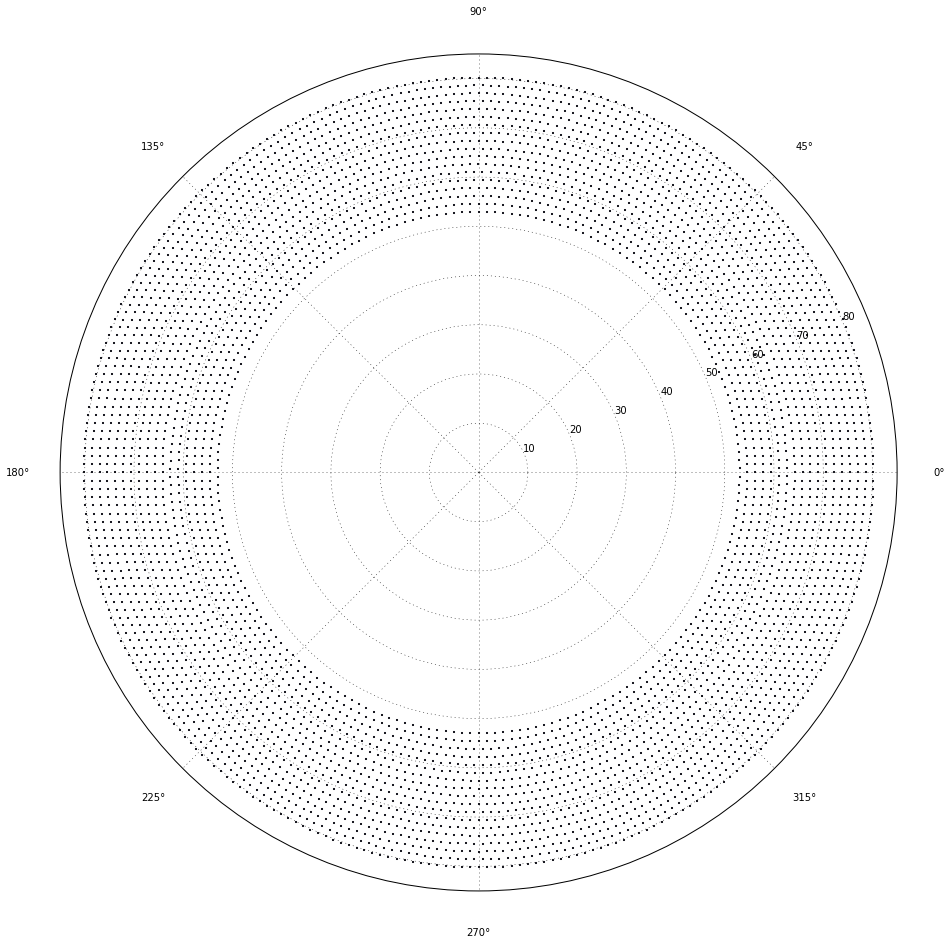

In [26]:
from scipy.sparse import *
wire_0 = 1250
neigh = find(test_neigh_2[wire_0,:])[1]
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()

scatter(phis, rhos, marker='.', s=5)

bad_neigh_index_2 = where( (bad_neighs_2!=0))

few_neigh_2 = where( ( (bad_neighs_2 <= 5) & (bad_neighs_2!=0) ) | (bad_neighs_2 == 7) )

many_neigh_2 = where( (bad_neighs_2 == 6) | (bad_neighs_2 >= 8)  ) 

print len(bad_neigh_index_2[0])
print len(many_neigh_2[0]) + len(few_neigh_2[0])

scatter(phis[few_neigh_2],rhos[few_neigh_2], marker='o', s=50, c='b')
scatter(phis[many_neigh_2],rhos[many_neigh_2], marker='o', s=50, c='r')

print bad_neigh_index_2

print len(find(test_neigh_2[:,32])[0])

In [ ]:

print signal.wire_phis[wire_0] - signal.wire_phis[neigh[-1]]
print signal.wire_phis[wire_0] - signal.wire_phis[neigh[-1]-1]

this_wire = wire_0
for n, firsts in enumerate(signal.first_wire):
    if this_wire > firsts:
        lay = n
    else:
        break
rel_pos = signal.wire_phis[this_wire]/(2*math.pi)
print "rel pos " + format(rel_pos)
above = rel_pos*(signal.wires_by_layer[lay + 1]-1)
print "above total wires " + format(signal.wires_by_layer[lay + 1])
print "above 1 " + format(above)
above += (signal.phi0_by_layer[lay + 1]/(2*math.pi))
print "above 2 " + format(above)
above = round(above)
print "above 3 " + format(above)
above %= signal.wires_by_layer[lay + 1]
print "above 4 " + format(above)
above += signal.first_wire[lay + 1]
print "above final " + format(above)
test_neigh_2[this_wire, above] = 1 # Above

In [269]:
from scipy.sparse import *
#for wire in enumerate(signal.total_wires)
plot = 0
bad_wires = np.zeros(signal.total_wires)
for wire in range(signal.total_wires):
    neigh = find(test_neigh_2[wire,:])[1]
    wire_a = signal.wire_phis[wire]
    if wire < signal.first_wire[-1]:
        neigh_of_above = find(test_neigh_2[neigh[-1],:])[1][1:3]
        above_a = signal.wire_phis[neigh[-1]]    
        for above_neigh in neigh_of_above:
            new_a = signal.wire_phis[above_neigh]
            if abs(wire_a - above_a) > abs(wire_a - new_a):
                bad_wires[wire] += 1
    if wire >= signal.first_wire[1]:
        if (wire < signal.first_wire[2]):
            neigh_of_below = find(test_neigh_2[neigh[0],:])[1][0:2] 
            below_a = signal.wire_phis[neigh[0]]    
            for below_neigh in neigh_of_below:
                new_a = signal.wire_phis[below_neigh]
                if abs(wire_a - below_a) > abs(wire_a - new_a):
                    bad_wires[wire] += 10    
        else :
            neigh_of_below = find(test_neigh_2[neigh[0],:])[1][1:3] 
            below_a = signal.wire_phis[neigh[0]]    
            for below_neigh in neigh_of_below:
                new_a = signal.wire_phis[below_neigh]
                if abs(wire_a - below_a) > abs(wire_a - new_a):
                    bad_wires[wire] += 10

set([0.0, 1.0, 10.0, 11.0, 22.0])
634
632


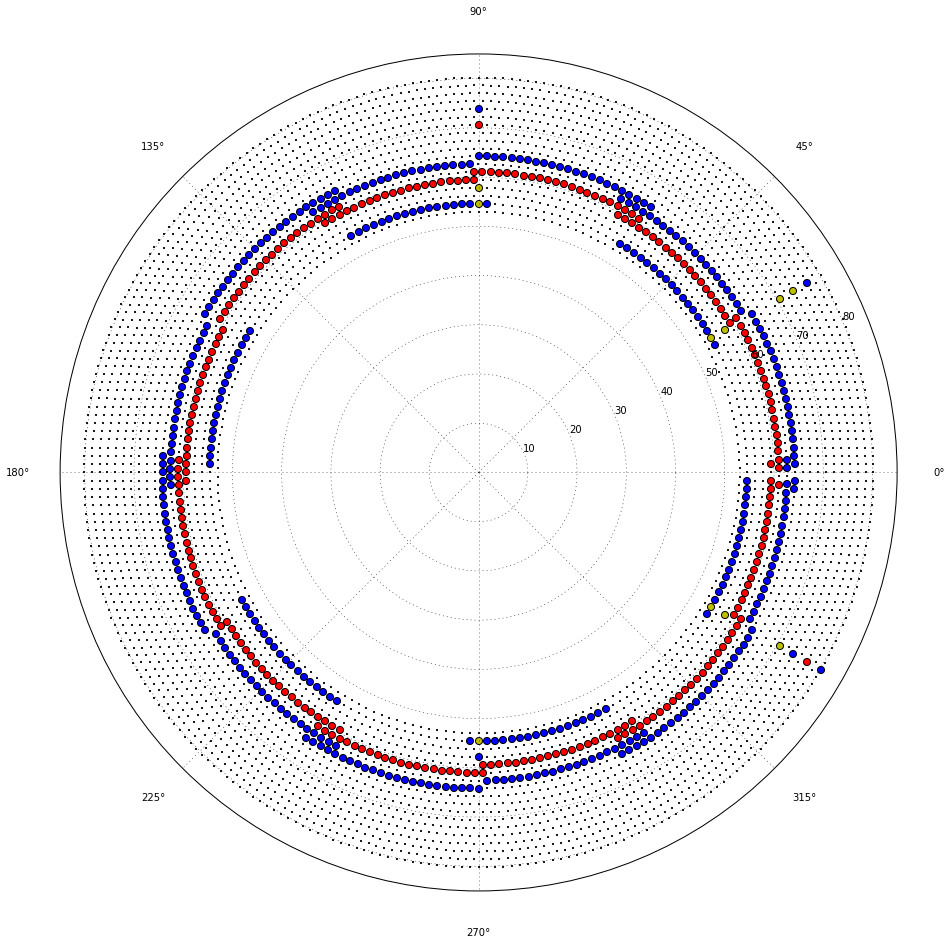

In [254]:
#old without phi_0 in the right place
bad_wires_old = bad_wires
from scipy.sparse import *
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()

scatter(phis, rhos, marker='.', s=5)

#scatter(phis[neigh],rhos[neigh], marker='o', c='b')
#scatter(phis[wire_0],rhos[wire_0], marker='o', s=50, c='r')

bad_wire_index = where( (bad_wires_old!=0))

print set(bad_wires_old)

bad_below = where( ( (bad_wires_old == 10) | (bad_wires_old == 20) ) )
bad_above = where( ( (bad_wires_old == 1) | (bad_wires_old == 2) ) )
bad_both = where( (bad_wires_old == 11) )


print len(bad_wire_index[0])
print len(bad_below[0]) + len(bad_above[0]) + len(bad_both[0])

scatter(phis[bad_below],rhos[bad_below], marker='o', s=50, c='b')
scatter(phis[bad_above],rhos[bad_above], marker='o', s=50, c='r')
scatter(phis[bad_both],rhos[bad_both], marker='o', s=50, c='y')

set([0.0, 1.0, 2.0, 10.0, 11.0, 20.0])
[ 630  666  810 2530 2750 3065]
[ 215  249  351  385  828 1069 1107 1221 1259 1511 2574 3864]
[ 198  774 1277 1512 3111 3295 3624 4457]
26
26


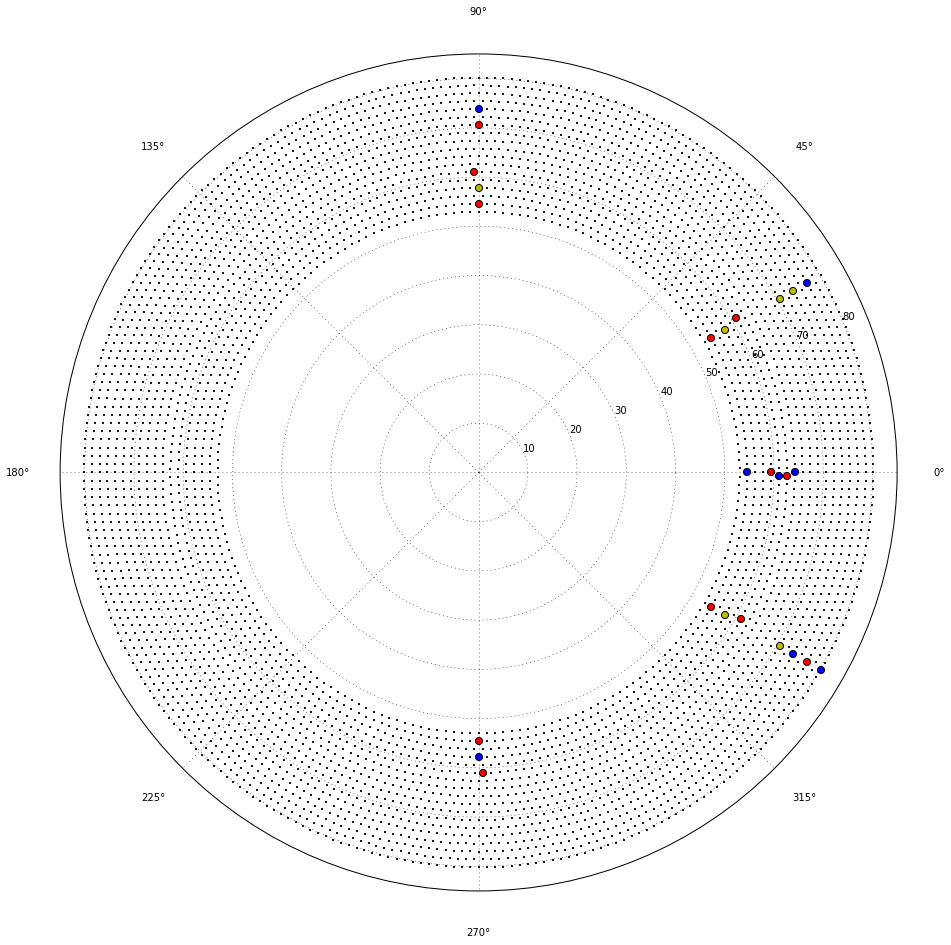

In [274]:
from scipy.sparse import *
setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()

scatter(phis, rhos, marker='.', s=5)

#scatter(phis[neigh],rhos[neigh], marker='o', c='b')
#scatter(phis[wire_0],rhos[wire_0], marker='o', s=50, c='r')

bad_wire_index = where( (bad_wires!=0))

print set(bad_wires)

bad_below = where( ( (bad_wires == 10) | (bad_wires == 20) ) )
bad_above = where( ( (bad_wires == 1) | (bad_wires == 2) ) )
bad_both = where( (bad_wires == 11) | (bad_wires == 22) )

print bad_both[0] 
print bad_above[0]
print bad_below[0]

print len(bad_wire_index[0])
print len(bad_below[0]) + len(bad_above[0]) + len(bad_both[0])

scatter(phis[bad_below],rhos[bad_below], marker='o', s=50, c='b')
scatter(phis[bad_above],rhos[bad_above], marker='o', s=50, c='r')
scatter(phis[bad_both],rhos[bad_both], marker='o', s=50, c='y')

In [291]:
for wire in bad_below[0]:
    neigh = find(test_neigh_2[wire,:])[1]
    neigh_of_below = find(test_neigh_2[neigh[0],:])[1]
    neigh_of_above = find(test_neigh_2[neigh[-1],:])[1]
    
    phi_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]] 
    left_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]-1]
    right_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]+1]
    if abs(phi_diff) - abs(left_diff) > 0.00000001 or abs(phi_diff) - abs(right_diff) > 0.00000001:    
        print "below"
        print wire, neigh[0], phi_diff
        print wire, neigh[0]-1, left_diff
        print wire, neigh[0]+1, right_diff

for wire in bad_above[0]:
    neigh = find(test_neigh_2[wire,:])[1]
    
    phi_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]] 
    left_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]-1]
    right_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]+1]
    if abs(phi_diff) - abs(left_diff) > 0.00000001 or abs(phi_diff) - abs(right_diff) > 0.00000001:    
        print "above"
        print wire, neigh[-1], phi_diff
        print wire, neigh[-1]-1, left_diff
        print wire, neigh[-1]+1, right_diff

for wire in bad_both[0]:
    neigh = find(test_neigh_2[wire,:])[1]
    
    phi_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]] 
    left_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]-1]
    right_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[-1]+1]
    if abs(phi_diff) - abs(left_diff) > 0.00000001 or abs(phi_diff) - abs(right_diff) > 0.00000001:    
        print "above"
        print wire, neigh[-1], phi_diff
        print wire, neigh[-1]-1, left_diff
        print wire, neigh[-1]+1, right_diff
        
    phi_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]] 
    left_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]-1]
    right_diff = signal.wire_phis[wire] - signal.wire_phis[neigh[0]+1]
    if abs(phi_diff) - abs(left_diff) > 0.00000001 or abs(phi_diff) - abs(right_diff) > 0.00000001:    
        print "below"
        print wire, neigh[0], phi_diff
        print wire, neigh[0]-1, left_diff
        print wire, neigh[0]+1, right_diff

 

below
198 197 -6.26731904805
198 196 -6.23558578893
198 198 0.0
below
1277 828 6.27058747688
1277 827 0.0164909905719
1277 829 6.24228484037
below
1512 1511 -6.27129408792
1512 1510 -6.24444286866
1512 1512 0.0
above
828 1277 -6.27058747688
828 1276 -6.24302964659
828 1278 -0.01496
above
1511 1512 6.27129408792
1511 1511 0.0
1511 1513 6.24511414914


In [321]:
wire =  signal.first_wire[4]
wire_0 = signal.first_wire[5]
wire_1 = signal.first_wire[5]+1
wire_2 = signal.first_wire[5]-1
phi_diff = signal.wire_phis[wire] - signal.wire_phis[wire_1] 
left_diff = signal.wire_phis[wire] - signal.wire_phis[wire_0]
right_diff = signal.wire_phis[wire] - signal.wire_phis[wire_2]

print wire, wire_1, phi_diff
print wire, wire_0, left_diff
print wire, wire_2, right_diff+2*math.pi

828 1051 -0.0425178302946
828 1050 -0.01496
828 1049 0.0283026365188


(array([0, 0, 0, 0, 0, 0, 0, 0], dtype=int32), array([ 681,  682,  683,  899,  901, 1122, 1123, 1124], dtype=int32), array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]))
8


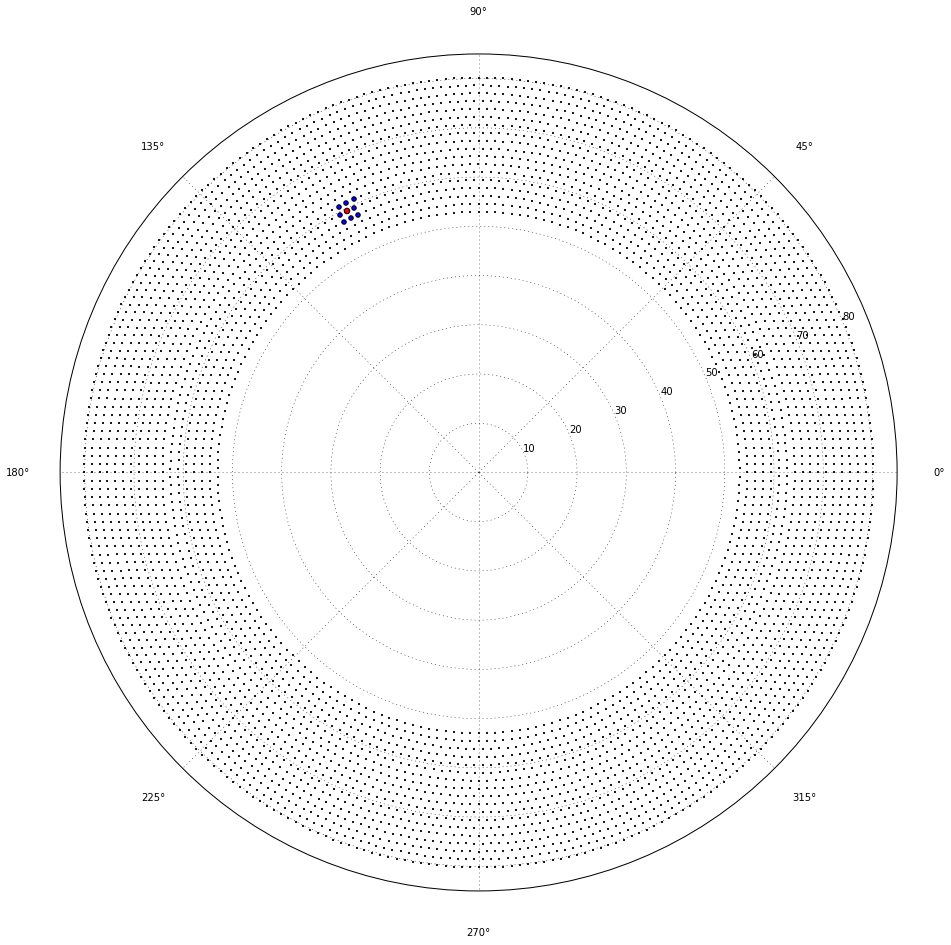

In [27]:
from scipy.sparse import *
#for wire in enumerate(signal.total_wires)
wire = 900
neigh = find(test_neigh_2[wire,:])
#neigh_of_below = find(test_neigh_2[neigh[0],:])[1][1:3]
#neigh_of_above = find(test_neigh_2[neigh[-1],:])[1][1:3]

print neigh

neigh = neigh[1]

setup_plot_for_detector()
rhos, phis = signal.get_wires_rhos_and_phis()
scatter(phis, rhos, marker='.', s=5)

scatter(phis[neigh],rhos[neigh], marker='o', c='b')
#scatter(phis[neigh_of_below],rhos[neigh_of_below], marker='o', c='y')
#scatter(phis[neigh_of_above],rhos[neigh_of_above], marker='o', c='g')

scatter(phis[wire],rhos[wire], marker='o', s=30, c='r')
print len(neigh)